In [1]:
import sys
import os
import scipy.io as sio
from scipy import interpolate
from netCDF4 import date2num
sys.path.append(os.environ['GOTMWORK_ROOT']+'/tools', )
from gotmanalysis import *
%matplotlib inline

In [2]:
# list of turbulent methods
turbmethod_list = ['KPP-CVMix',
                   'KPP-ROMS',
                   'KPPLT-EFACTOR',
                   'KPPLT-ENTR',
                   'KPPLT-RWHGK',
                   'EPBL',
                   'EPBL-LT',
                   'SMC',
                   'SMCLT',
                   'K-EPSILON-SG',
                   'OSMOSIS']
legend_list = ['KPP-CVMix',
               'KPP-ROMS',
               'KPPLT-VR12',
               'KPPLT-LF17',
               'KPPLT-R16',
               'ePBL',
               'ePBL-LT',
               'SMC-KC94',
               'SMCLT-H15',
               'k-epsilon',
               'OSMOSIS']
nm = len(turbmethod_list)
bcolor = ['lightcyan','lightblue','greenyellow','lightpink','palegoldenrod',
          'turquoise', 'deepskyblue','royalblue','forestgreen','firebrick','mediumpurple']
dir_in = os.environ['GOTMRUN_ROOT']+'/Idealized_Hurricane'
dir_out = os.environ['GOTMFIG_ROOT']+'/Idealized_Hurricane'
# list of location
irow_2col = [1, 2, 0, 1, 2, 3, 3, 4, 4, 5, 5]
icol_2col = [0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1]
labels_2col = ['(b)', '(c)', '(g)', '(h)', '(i)', '(d)', '(j)', '(e)', '(k)','(f)','(l)']


In [3]:
# paths of files 
nm = len(turbmethod_list)
paths = [dir_in+'/'+turbmethod_list[i]+'/STORAGE/gotm_out_046.nc' for i in range(nm)]
path_les = os.environ['HOME']+'/data/R16/TC021_PROF.mat'
# initialize dataset
data_gotm = GOTMOutputDataSet(paths=paths, keys=turbmethod_list)
data_les = sio.loadmat(path_les)

In [4]:
# constants
# gravity (m/s^2)
g = 9.81;
# water density (kg/m^3)
rho = 1027;
# temperature expansion coefficent (K^{-1})
alpha = 1/5000;

In [5]:
# output figure name
os.makedirs(dir_out, exist_ok=True)


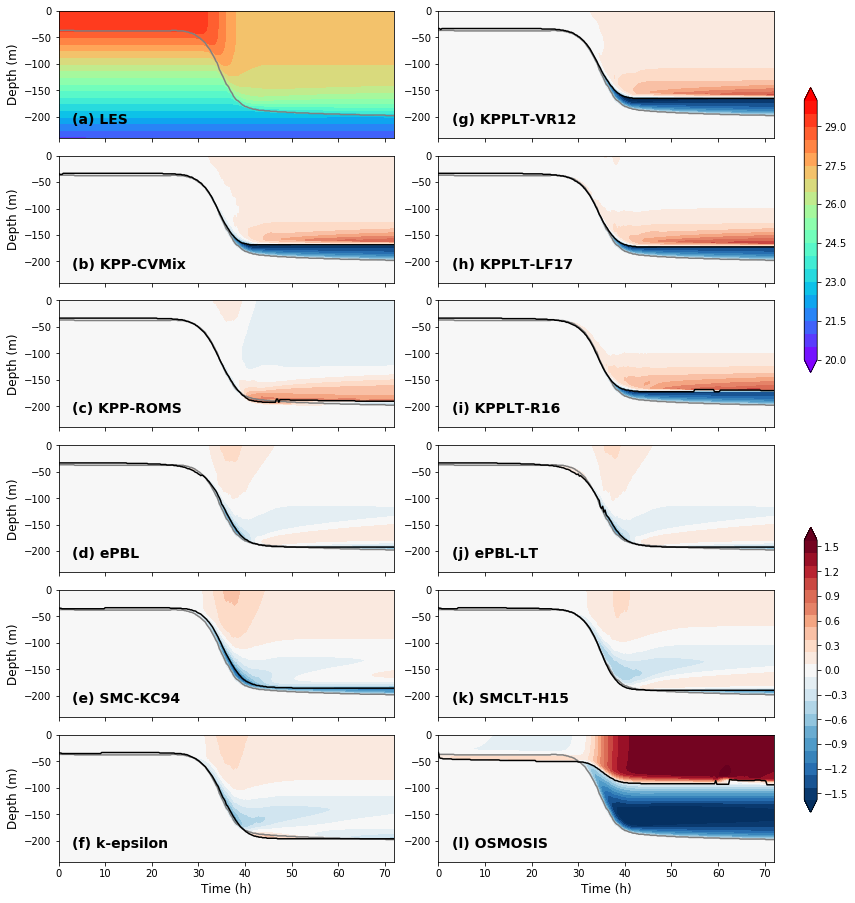

In [7]:
# figure 1: temperature profiles
nrow = (nm+2)//2
fig_width = 12
fig_height = 3+2*(nrow-1)

# plot figure
height_ratios = [1]*nrow
height_ratios.append(0.15)
width_ratios = [1, 1, 0.05]
f, axarr = plt.subplots(nrow, 2, sharex='col')
f.set_size_inches(fig_width, fig_height)

# contour levels
c_max = 30
c_min = 20
d_max = 1.5
depth = -240
c_int = (c_max-c_min)/20
levels0 = np.arange(c_min, c_max+c_int, c_int)
d_int = d_max/10
levels1 = np.arange(-d_max-0.5*d_int, d_max+d_int, d_int)
cb_ticks = np.arange(-d_max, d_max+d_int*2, d_int*2)
    
# panel a
# get coordinates in GOTM
gotmdata0 = data_gotm.cases['KPP-CVMix']
prfl = gotmdata0.read_profile('temp')
z0 = prfl.z
time0 = gotmdata0.time/3600

# interpolate LES data onto GOTM grid
time_les = data_les['t'].flatten()/3600
z_les = data_les['z'].flatten()
temp_les = data_les['T']-273.15
f = interpolate.interp2d(-z_les, time_les, temp_les)
fld0 = f(z0, time0)

# plot
im0 = axarr[0, 0].contourf(time0, z0, np.transpose(fld0), levels0, extend='both', cmap='rainbow')
axarr[0, 0].set_ylabel('Depth (m)', fontsize=12)
axarr[0, 0].set_ylim([depth, 0]) 
axarr[0, 0].set_xlim([0, 72]) 

# get mld defined by maximum N^2
NN = (fld0[:,1:]-fld0[:,0:-1])/(z0[1:]-z0[0:-1])
zw = 0.5*(z0[1:]+z0[0:-1])
idx_max = np.argmax(NN, 1)
nt = time0.size
mld0 = np.zeros(nt)
for i in np.arange(nt):                                                                                                                                          
    mld0[i] = -zw[idx_max[i]]

axarr[0, 0].plot(time0, -mld0, color='gray', linewidth=1.5)
axarr[0, 0].text(0.04, 0.2, '(a) LES', transform=axarr[0, 0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')

# panel b-l
# loop over other turbmethods
cmap = plt.cm.get_cmap('RdBu_r', 61)
for i in np.arange(nm):
    j = i 
    n = icol_2col[j]
    m = irow_2col[j]
    gotmdata1 = data_gotm.cases[turbmethod_list[j]]
    time1 = gotmdata1.time/3600
    # get var
    prfl = gotmdata1.read_profile('temp')
    fld1 = prfl.data
    z1 = prfl.z
    # get mld
    mld1 = gotmdata1.read_timeseries('mld_maxNsqr').data
    im1 = axarr[m, n].contourf(time1, z1, np.transpose(fld1-fld0), levels1, extend='both', cmap=cmap)
    if n == 0:
        axarr[m, n].set_ylabel('Depth (m)', fontsize=12)
    if m == nrow-1:
        axarr[m, n].set_xlabel('Time (h)', fontsize=12)
    axarr[m, n].set_ylim([depth, 0]) 
    axarr[m, n].set_xlim([0, 72]) 
    axarr[m, n].plot(time0, -mld0, color='gray', linewidth=1.5)
    axarr[m, n].plot(time1, -mld1, color='black', linewidth=1.5)
    axarr[m, n].text(0.04, 0.2, labels_2col[j]+' '+legend_list[j], transform=axarr[m, n].transAxes, fontsize=14, 
                     fontweight='bold', va='top')

 # reduce margin
plt.tight_layout()

plt.subplots_adjust(bottom=0.075, right=0.9)
cax0 = plt.axes([0.85, 0.55, 0.1, 0.4])
cax0.set_visible(False)
cb0 = plt.colorbar(im0, ax=cax0)
cb0.formatter.set_powerlimits((-2, 2)) 
cb0.update_ticks()
cax1 = plt.axes([0.85, 0.08, 0.1, 0.4])
cax1.set_visible(False)
cb1 = plt.colorbar(im1, ax=cax1, ticks=cb_ticks)
cb1.formatter.set_powerlimits((-2, 2)) 
cb1.update_ticks()

# save figure
figname = dir_out+'/Pfl_cmp_turbmethods_temp.png'
plt.savefig(figname, dpi = 300)

# # close figure
# plt.close()

In [92]:
def plot_SST(data_les, data_gotm, turbmethod_list, bcolor, axis=None, xlabel_on=True):

    if axis is None:
        ax = plt.gca()
    else:
        ax = axis
        
    # twin axis
    par1 = ax.twinx()
    
    # LES
    time_les = data_les['t'].flatten()/3600
    temp_les = data_les['T']-273.15
    sst_les = temp_les[:,0]
    gotmdata0 = data_gotm.cases['KPP-CVMix']
    time0 = gotmdata0.time/3600
    ts0 = np.interp(time0, time_les, sst_les)
    par1.plot(time_les, sst_les, color='lightgray', linewidth=3, linestyle='--')
    par1.set_ylabel('SST ($^\circ$C)', fontsize=14)
    for label in (par1.get_xticklabels() + par1.get_yticklabels()):
        label.set_fontsize(14)
        
    # GOTM
    for i in np.arange(nm):
        gotmdata1 = data_gotm.cases[turbmethod_list[i]]
        time1 = gotmdata1.time/3600
        # get var
        prfl = gotmdata1.read_profile('temp')
        ts1 = prfl.data[:,-1]
        ax.plot(time1, ts1-ts0, color=bcolor[i])
        ax.axhline(y=0, color='k', linewidth=1)

    ax.set_ylabel('$\Delta$ SST ($^\circ$C)', fontsize=14)
    ax.set_ylim([-0.3, 0.5])
    if xlabel_on:
        ax.set_xlabel('Time (h)', fontsize=14)
    ax.set_xlim([2, 72])
    ax.set_zorder(par1.get_zorder()+1)
    ax.patch.set_visible(False)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)

    
def plot_PE(data_les, data_gotm, turbmethod_list, bcolor, axis=None, xlabel_on=True):
    
    if axis is None:
        ax = plt.gca()
    else:
        ax = axis
        
    # twin axis
    par1 = ax.twinx()

    # LES
    time_les = data_les['t'].flatten()/3600
    temp_les = data_les['T']-273.15
    zu_les = -data_les['z'].flatten()
    zw_les = np.zeros(zu_les.size+1)
    zw_les[0] = 0.0
    zw_les[1:-1] = 0.5*(zu_les[0:-1]+zu_les[1:])
    zw_les[-1] = -240.0
    bxym_les = temp_les*g*alpha
    zbot_les = zw_les[-1]
    dz_les = zw_les[0:-1]-zw_les[1:]
    nt_les = time_les.size
    epot_les = np.zeros(nt_les)
    for k in np.arange(nt_les):
        epot_les[k] = np.sum(dz_les*bxym_les[k,:]*(zbot_les-zu_les))

    epot_les = epot_les - epot_les[0]
    epot_les = epot_les*rho

    gotmdata0 = data_gotm.cases['KPP-CVMix']
    time0 = gotmdata0.time/3600
    ts0 = np.interp(time0, time_les, epot_les)
    par1.plot(time_les, epot_les, color='lightgray', linewidth=3, linestyle='--')
    par1.set_ylabel('PE (J m$^{-2}$)', fontsize=14)
    par1.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
    par1.yaxis.offsetText.set_fontsize(14)
    for label in (par1.get_xticklabels() + par1.get_yticklabels()):
        label.set_fontsize(14)

    # GOTM
    for i in np.arange(nm):
        gotmdata1 = data_gotm.cases[turbmethod_list[i]]
        time1 = gotmdata1.time/3600
        # get var
        ts1 = gotmdata1.read_timeseries('Epot').data
        ax.plot(time1, ts1-ts0, color=bcolor[i])
        ax.axhline(y=0, color='k', linewidth=1)

    ax.set_ylabel('$\Delta$ PE (J m$^{-2}$)', fontsize=14)
    ax.set_ylim([-1e4, 0.5e4])
    if xlabel_on:
        ax.set_xlabel('Time (h)', fontsize=14)
    ax.set_xlim([2, 72])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
    ax.yaxis.offsetText.set_fontsize(14)
    ax.set_zorder(par1.get_zorder()+1)
    ax.patch.set_visible(False)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)

    
def plot_surface_forcing(data_gotm, axis=None, xlabel_on=True):

    if axis is None:
        ax = plt.gca()
    else:
        ax = axis
        
    # twin axis
    par1 = ax.twinx()
    
    gotmdata0 = data_gotm.cases['KPP-CVMix']
    time0 = gotmdata0.time/3600
    ustar = gotmdata0.read_timeseries('u_taus').data
    us0 = gotmdata0.read_timeseries('u0_stokes').data
    vs0 = gotmdata0.read_timeseries('v0_stokes').data
    ustokes = np.sqrt(us0**2+vs0**2)
    laturb = np.where(ustokes>0, np.sqrt(ustar/ustokes), np.nan)
    ax.plot(time0, ustar, color='k')
    ax.set_ylabel('$u_*$ (m s$^{-1}$)', fontsize=14)
    ax.set_ylim([0.0, 0.1])
    for label in (par1.get_xticklabels() + par1.get_yticklabels()):
        label.set_fontsize(14)

    par1.plot(time0, laturb, color='k', linestyle='--')
    par1.set_ylabel('La$_t$', fontsize=14)
    par1.set_ylim([0.2, 1.2])
    if xlabel_on:
        ax.set_xlabel('Time (h)', fontsize=14)
    ax.set_xlim([2, 72])
    ax.set_zorder(par1.get_zorder()+1)
    ax.patch.set_visible(False)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)
    
    
def plot_profile_temperature(data_les, axis=None, xlabel_on=True):
    
    if axis is None:
        ax = plt.gca()
    else:
        ax = axis
    c_max = 30
    c_min = 20
    c_int = (c_max-c_min)/20
    levels0 = np.arange(c_min, c_max+c_int, c_int)

    time_les = data_les['t'].flatten()/3600
    z_les = data_les['z'].flatten()
    temp_les = data_les['T']-273.15

    # plot
    im0 = ax.contourf(time_les, -z_les, np.transpose(temp_les), levels0, extend='both', cmap='magma')
    ax.set_ylabel('Depth (m)', fontsize=14)
    ax.set_ylim([-240, 0]) 
    if xlabel_on:
        ax.set_xlabel('Time (h)', fontsize=14)
    ax.set_xlim([2, 72]) 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)

    # get mld defined by maximum N^2
    fld0 = temp_les
    z0 = -z_les
    NN = (fld0[:,1:]-fld0[:,0:-1])/(z0[1:]-z0[0:-1])
    zw = 0.5*(z0[1:]+z0[0:-1])
    idx_max = np.argmax(NN, 1)
    nt = time_les.size
    mld0 = np.zeros(nt)
    for i in np.arange(nt):                                                                                                                                          
        mld0[i] = -zw[idx_max[i]]
    ax.plot(time_les, -mld0, color='white', linewidth=1.5)
    return im0

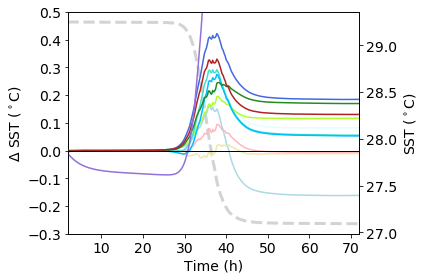

In [85]:
# figure 2: SST
f2 = plt.figure()
f2.set_size_inches(6, 4)
plot_SST(data_les, data_gotm, turbmethod_list, bcolor)
# reduce margin
plt.tight_layout()
# save figure
figname = dir_out+'/ts_cmp_turbmethods_SST.png'
plt.savefig(figname, dpi = 300)

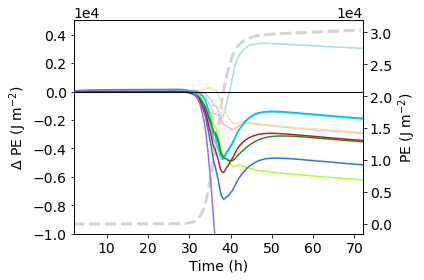

In [93]:
# figure 3: PE
f3 = plt.figure()
f3.set_size_inches(6, 4)
plot_PE(data_les, data_gotm, turbmethod_list, bcolor)

# reduce margin
plt.tight_layout()
# save figure
figname = dir_out+'/ts_cmp_turbmethods_PE.png'
plt.savefig(figname, dpi = 300)

/Users/qingli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide
/Users/qingli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in true_divide


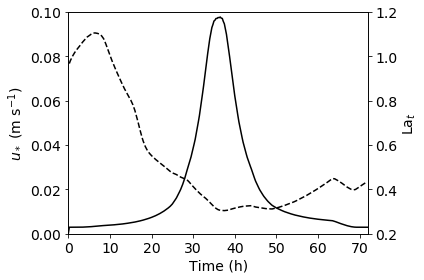

In [11]:
# figure 4: Surface forcing
f4 = plt.figure()
f4.set_size_inches(6, 4)
plot_surface_forcing(data_gotm)

# reduce margin
plt.tight_layout()
# save figure
figname = dir_out+'/ts_surface_forcing.png'
plt.savefig(figname, dpi = 300)

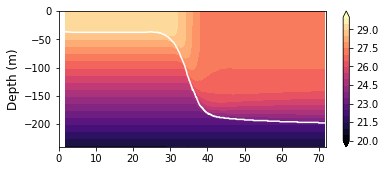

In [12]:
# figure 5: temperature profile
f5 = plt.figure()
f5.set_size_inches(6, 2.5)
im0 = plot_profile_temperature(data_les)

cb0 = plt.colorbar(im0)
cb0.formatter.set_powerlimits((-2, 2)) 
cb0.update_ticks()

# save figure
figname = dir_out+'/prfl_temp.png'
plt.savefig(figname, dpi = 300)

/Users/qingli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in true_divide
/Users/qingli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
/Users/qingli/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


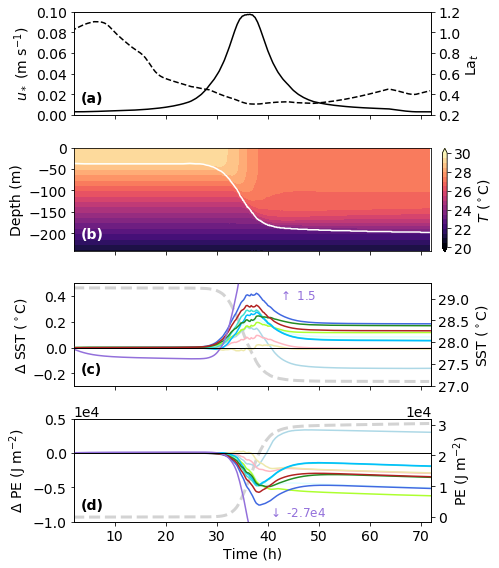

In [96]:
# figure 6: all together
f6, axarr = plt.subplots(4, 1, sharex='col')
f6.set_size_inches(7, 8)

xx = 0.02
yy = 0.23
plot_surface_forcing(data_gotm, axis=axarr[0], xlabel_on=False)
axarr[0].text(xx, yy, '(a)', color='black', transform=axarr[0].transAxes,
             fontsize=14, fontweight='bold', va='top', ha='left')
im0 = plot_profile_temperature(data_les, axis=axarr[1], xlabel_on=False)
axarr[1].text(xx, yy, '(b)', color='white', transform=axarr[1].transAxes,
             fontsize=14, fontweight='bold', va='top', ha='left')
plot_SST(data_les, data_gotm, turbmethod_list, bcolor, axis=axarr[2], xlabel_on=False)
axarr[2].text(xx, yy, '(c)', color='black', transform=axarr[2].transAxes,
             fontsize=14, fontweight='bold', va='top', ha='left')
plot_PE(data_les, data_gotm, turbmethod_list, bcolor, axis=axarr[3])
axarr[3].text(xx, yy, '(d)', color='black', transform=axarr[3].transAxes,
             fontsize=14, fontweight='bold', va='top', ha='left')

# label values outside the plot box
axarr[2].text(42, 0.45, r'$\uparrow$ 1.5', color=bcolor[-1], fontsize=12, va='top', ha='left')
axarr[3].text(40, -0.77e4, r'$\downarrow$ -2.7e4', color=bcolor[-1], fontsize=12, va='top', ha='left')


plt.subplots_adjust(bottom=0.075, right=0.9)
cb_ticks = np.arange(6)*2+20
cax0 = plt.axes([0.8, 0.555, 0.1, 0.18])
cax0.set_visible(False)
cb0 = plt.colorbar(im0, ax=cax0, ticks=cb_ticks)
cb0.set_label('$T$ ($^\circ$C)', fontsize=14)
cb0.formatter.set_powerlimits((-2, 2)) 
cb0.ax.set_yticklabels(cb0.ax.get_yticklabels(), fontsize=14)

# # legend
# xshift = 0.122
# xx = np.arange(nm)+1
# xx = xx*0.06+xshift
# yy = -np.ones(xx.size)*0.5
# for i in np.arange(nm):
# #     plt.text(xx[i], yy[i], legend_list[i], color=bcolor[i], transform=ax.transAxes,
# #              fontsize=12, fontweight='bold', rotation=45, va='bottom', ha='left')
#     axarr[3].text(xx[i], yy[i], legend_list[i], color='black', transform=axarr[3].transAxes,
#              fontsize=10, rotation=30, va='top', ha='right')
#     axarr[3].scatter(xx[i], yy[i]+0.07, s=40, c=bcolor[i], edgecolors='k', linewidth=1,
#                      transform=axarr[3].transAxes, clip_on=False)

# reduce margin
plt.tight_layout()
# save figure
figname = dir_out+'/ts_all.png'
plt.savefig(figname, dpi = 300)